# Check MUSIC on generated signals

## Imports and Constants

In [2]:
import math
import os
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft
from sklearn.metrics import confusion_matrix, accuracy_score

# Label resolution of angles
RESOLUTION = 50

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\training'

# Number of microphones
MICS_NUMBER = 2
MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

## Test on MUSIC

In [3]:
def compute_stft_matrix(observation, nfft=256):    
    # Default value for overlap
    step = nfft // 2
    
    # Calculate multidimensional STFT and return
    transformed_observation = stft.analysis(observation, L=nfft, hop=step)
    return np.transpose(transformed_observation, axes=[2, 1, 0])



def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=RESOLUTION, music=False, interp=1):
    # Lists of observations and labels that will be populated
    X = []
    y = []
    rounded_label = round(label / resolution) * resolution
    if rounded_label == 360: rounded_label = 0
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        y.append(rounded_label)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        if music:
            # Transform observation into a STFT matrix
            transformed_observation = compute_stft_matrix(observation)
            
        X.append(transformed_observation)

    return X, y



def get_music_prediction(X, room_size='small', resolution=RESOLUTION, fs=16000, nfft=256):    
    # Run MUSIC algorithm for DOA
    x = ROOMS[room_size][0]/2
    y = ROOMS[room_size][1]/2
    z = ROOMS[room_size][2]/2
    mic_loc=np.c_[[x + 0.2, y, z],[ x - 0.2, y, z]]

    doa = pra.doa.MUSIC(mic_loc, fs, nfft, n_grid=(360 // resolution), num_src=1)
    doa.locate_sources(X)
    
    return round((doa.azimuth_recon[0] * 180 / math.pi))



def get_all_predictions(is_info=False, samples=20, step=5, resolution=RESOLUTION):    
    y_true = []
    y_pred = []
    info = []
    
    files = [file for file in os.listdir(AUDIO_PATH) if 'test' in file]
    
    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue

        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X, y = create_observations(wav_signals, fs, label, samples, step, resolution, True)

        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        y = [(dist, room, label) for label in y]
           
        # Store actual and predicted labels
        y_true.extend(y)
        preds = [get_music_prediction(x, resolution=resolution, fs=fs) for x in X]
        y_pred.extend(preds)
        
        print(f'File {i+1}/{len(files)}', end='\r')
       
    y_true = np.array(y_true)
    
    info = y_true[:, :-1]
    y_true = list(y_true[:, -1].astype(int))
    return y_true, y_pred, info

In [4]:
y_true, y_pred, info = get_all_predictions(True, samples=SAMPLES, step=STEP, resolution=RESOLUTION)

In [70]:
def plot_cm(y_true, y_pred, class_names, font_scale=0.8):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    fig, ax = plt.subplots(figsize=(24, 20)) 
    ax = sns.heatmap(cm, annot=True, fmt=".3f", ax=ax)

    plt.ylabel('Actual', fontsize=24)
    plt.xlabel('Predicted', fontsize=24)
    plt.show()
    
    
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = sum(min(abs(y_t - y_p), (360 - abs(y_t - y_p))) ** 2 for y_t, y_p in zip(y_true, y_pred))
    rms = ((total / len(y_true)) ** 0.5)
    
    if type(rms) == np.ndarray:
        rms = rms[0]
        
    return round(rms, 3)

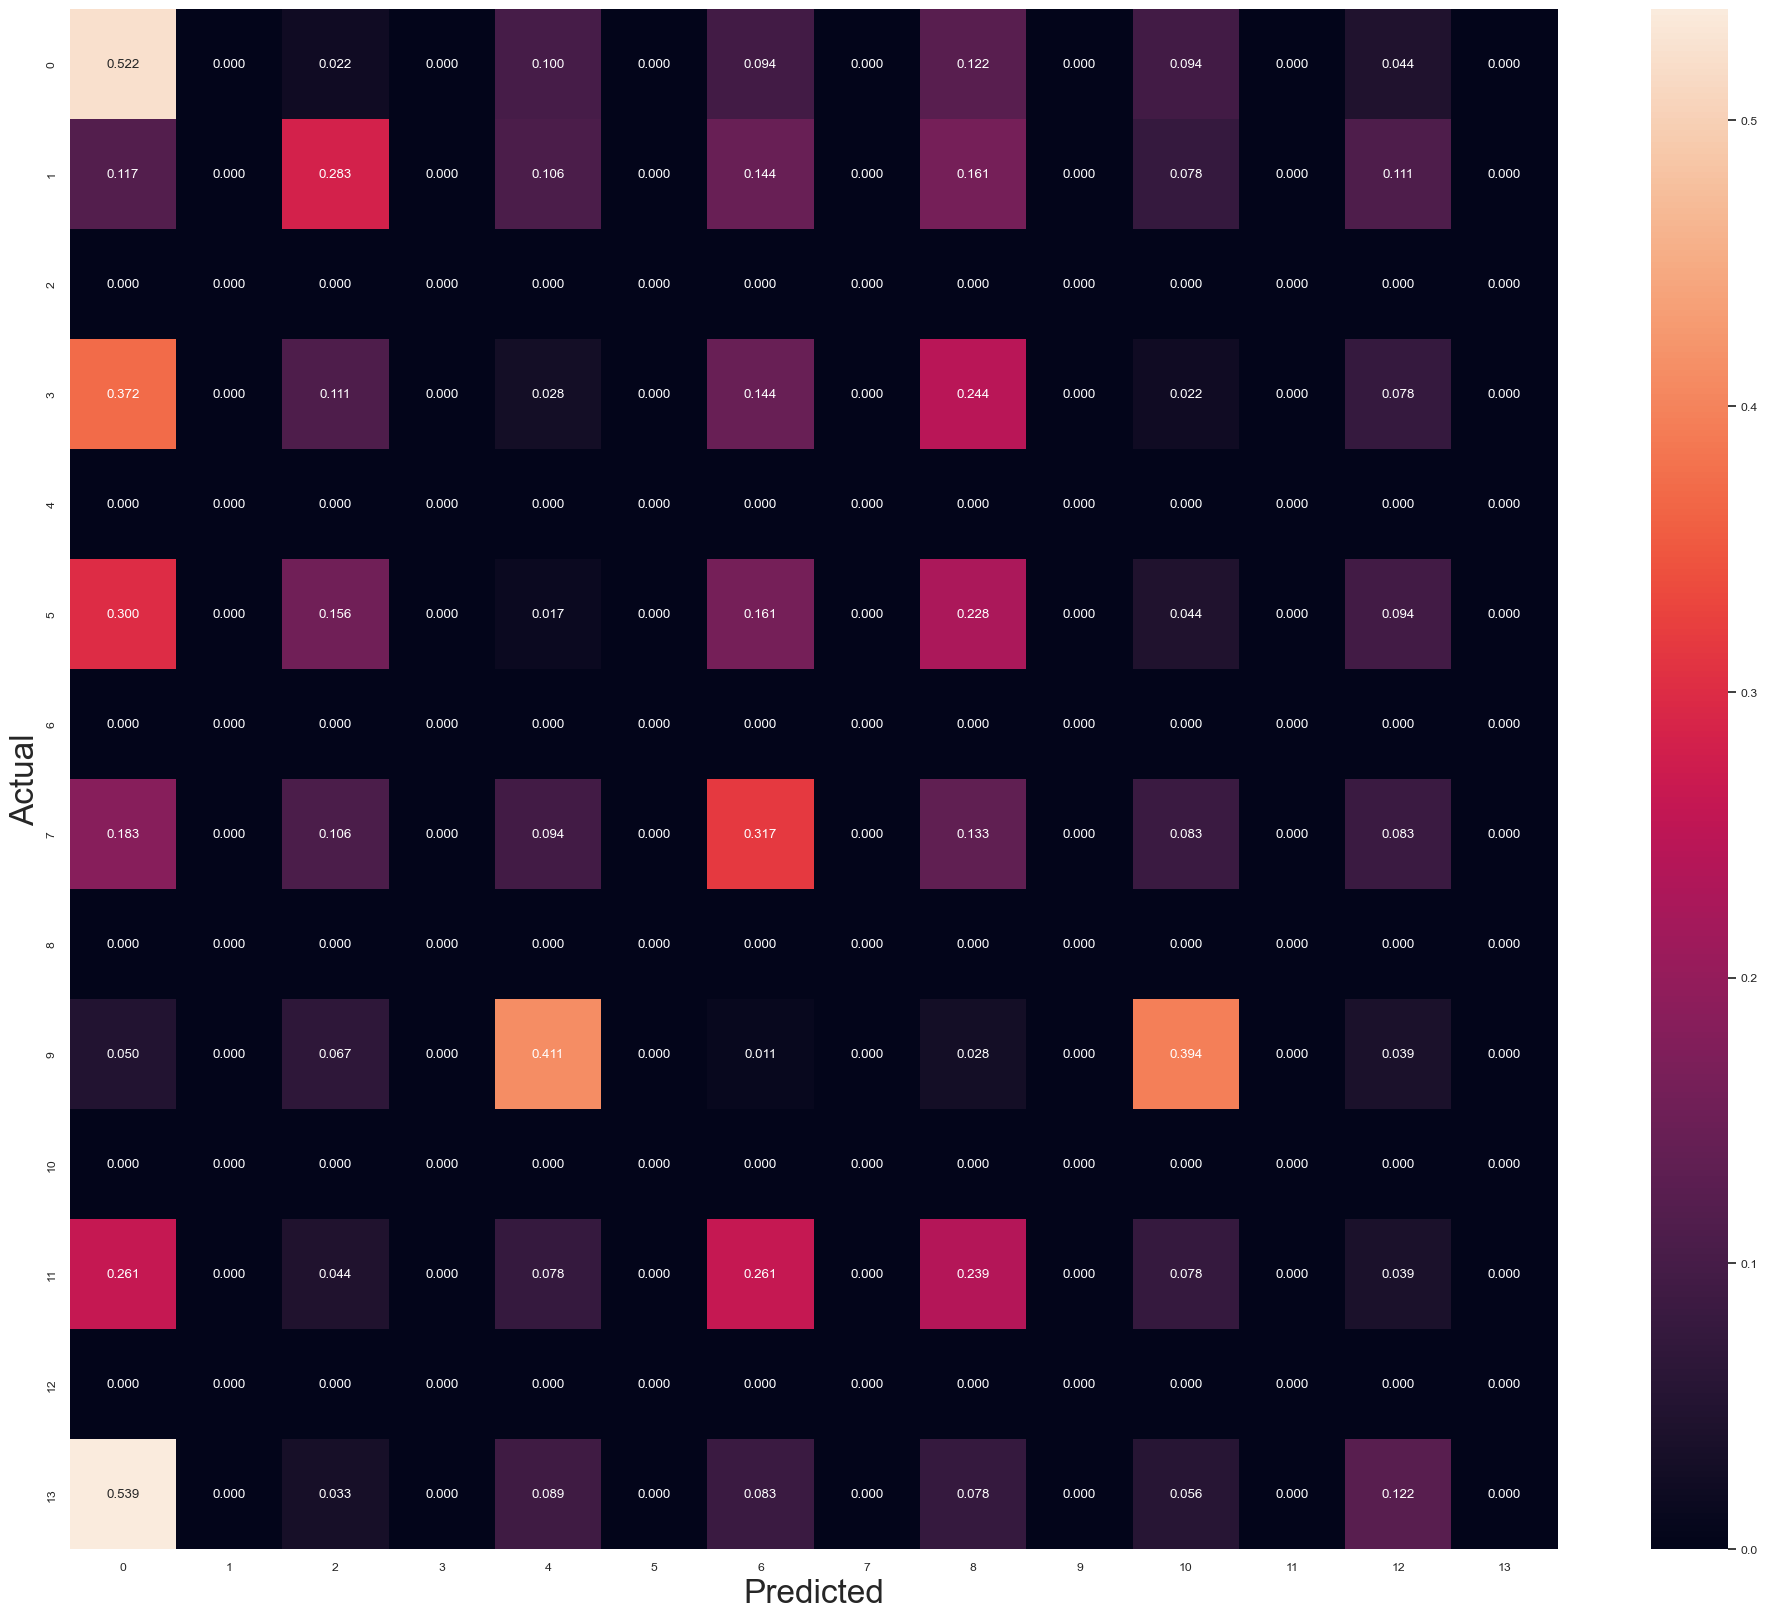

Accuracy: 0.065
RMSE: 97.739


In [71]:
# Plot confusion matrix and report accuracy
plot_cm(y_true, y_pred, np.arange(0, 360, 20))
accuracy = accuracy_score(y_true, y_pred)

print(f'Accuracy: {round(accuracy, 3)}')
print(f'RMSE: {rmse(y_true, y_pred)}')

In [75]:
def get_entries_with_property(info, prop, value):
    if prop == 'distance': i = 0
    elif prop == 'room': i = 1
        
    info = info[:, i]
    return np.where(info == value)

# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    indices = get_entries_with_property(info, 'room', room)
    y_true_room, y_pred_room = np.take(y_true, indices)[0], np.take(y_pred, indices)[0]
    accuracy = accuracy_score(y_true_room, y_pred_room)
    print(f"- {room} room accuracy: {round(accuracy, 3)}")
    
print('\nDistances')
for dist in np.unique(info[:, 0]):
    indices = get_entries_with_property(info, 'distance', dist)
    y_true_dist, y_pred_dist = np.take(y_true, indices)[0], np.take(y_pred, indices)[0]
    accuracy = accuracy_score(y_true_dist, y_pred_dist)
    print(f"- {dist} cm distance accuracy: {round(accuracy, 3)}")

Room sizes
- small room accuracy: 0.083
- medium room accuracy: 0.05
- large room accuracy: 0.062

Distances
- 100 cm distance accuracy: 0.079
- 200 cm distance accuracy: 0.051
